In [1]:
# import all the necessary libraries for time-seires analysis and network analysis
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import os
import sys
import math
import random
import itertools
import operator
import collections
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
import osmnx as ox
import contextily as ctx
import geopandas as gpd

c:\Users\SBH\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Download network from OSMNX

In [2]:
# define the hyperparameters for the network analysis
# the number of edges for each node
cut_num = 6
year = 2022
alpha = 1
beta1 = 0.8
beta2 = 1
gamma = 1
# alpha is commodity ratio in each industry
# beta is the self-supply ratio in each industry

In [3]:
"""
# define the area
places = ["Jiangsu, China", "Anhui, China", "Shanghai, China", "Zhejiang, China"]

# download the road network data
graphs = []
for place in places:
    G = ox.graph_from_place(place, network_type='drive')
    graphs.append(G)

# combine all the road networks by composing them
G_combined = nx.compose_all(graphs)

output_file = 'Data/python/combined_road_network.graphml'
ox.save_graphml(G_combined, output_file)
"""

'\n# define the area\nplaces = ["Jiangsu, China", "Anhui, China", "Shanghai, China", "Zhejiang, China"]\n\n# download the road network data\ngraphs = []\nfor place in places:\n    G = ox.graph_from_place(place, network_type=\'drive\')\n    graphs.append(G)\n\n# combine all the road networks by composing them\nG_combined = nx.compose_all(graphs)\n\noutput_file = \'Data/python/combined_road_network.graphml\'\nox.save_graphml(G_combined, output_file)\n'

### Import the Industry Dataset

In [4]:
# import the BEA code dataset
BEA = pd.read_csv('Data/python/BEAcode.csv')
# remove all the NA columns in the dataset
BEA = BEA.dropna(axis=1, how='all')
#BEA

In [5]:
# import the CN code dataset
CN = pd.read_csv('Data/python/CNcode.csv')
# remove all the NA columns in the dataset
CN = CN.dropna(axis=1, how='all')
# remove all the NA rows in the dataset
CN = CN.dropna(axis=0, how='all')
# change the CN_code column to integer
CN['CN_code'] = CN['CN_code'].astype(int)
#CN

In [6]:
# import the concordance dataset
concordance = pd.read_csv('Data/python/Concordance.csv')
# remove all the NA columns in the dataset
concordance = concordance.dropna(axis=1, how='all')
# remove all the NA rows in the dataset
concordance = concordance.dropna(axis=0, how='all')
#concordance

In [7]:
# import the matrix dataset, and set the first column as the index
matrix = pd.read_csv('Data/python/IOMatrix.csv', index_col=0)
# fill all the NA values with 0
matrix = matrix.fillna(0)
# convert all the values in the matrix to float
matrix = matrix.astype(float)
# for each value in the matrix, divide it by the last column's value of this row , last column is 'total'
matrix = matrix.div(matrix['total'], axis=0)
# drop the last column of the matrix
matrix = matrix.drop('total', axis=1)
# print if the matrix's index is the same as the columns
#matrix.index == matrix.columns
#matrix

In [8]:
# c reate a 23*23 matrix to store the summary results
CN_codelist = concordance['concordance_CN_code'].unique()
result_matrix = pd.DataFrame(np.zeros((len(CN_codelist), len(CN_codelist))), 
                             index=CN_codelist, columns=CN_codelist)

In [9]:
# delete all the commas in the matrix so as to convert all values to float
matrix = matrix.replace(',', '', regex=True)
# convert all the values in the matrix to float
matrix = matrix.astype(float)
# check NA values in the matrix
#matrix.isna().sum().sum()

In [10]:
for CN_code_i in CN_codelist:
    for CN_code_j in CN_codelist:
        BEA_code_i = concordance[concordance['concordance_CN_code'] == CN_code_i]['IO_code_BEA'].values[0]
        BEA_code_j = concordance[concordance['concordance_CN_code'] == CN_code_j]['IO_code_BEA'].values[0]
        result_matrix.loc[CN_code_i, CN_code_j] = matrix.loc[BEA_code_i, BEA_code_j].sum().sum()

In [11]:
# save the result matrix to a csv file and save the index and columns
#result_matrix.to_csv('Data/python/Depend_matrix.csv', index=True, header=True)

### Import the cities dataset


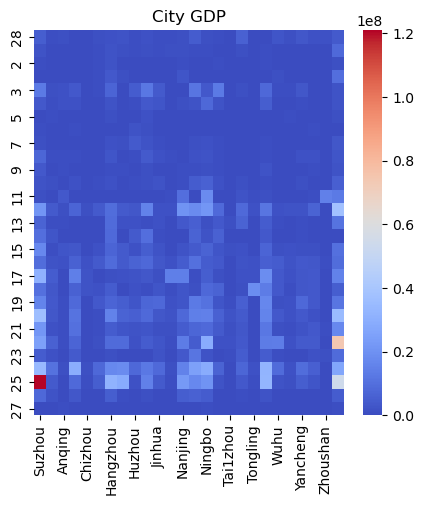

In [12]:
path = f'Data/python/CityIndustry/CityIndustry{year}.csv'
city_GDP = pd.read_csv(path, index_col=0,header=0)
#plot the heatmap of the city GDP
plt.figure(figsize=(5, 5))
sns.heatmap(city_GDP, cmap='coolwarm', fmt=".2f")
plt.title('City GDP')
plt.show()

In [13]:
# reindex  result_matrix 's index based on city's index
result_matrix_reindex = result_matrix.reindex(city_GDP.index)
#  reorder  result_matrix 's columns based on city's index
result_matrix_reindex = result_matrix_reindex.reindex(columns=city_GDP.index)

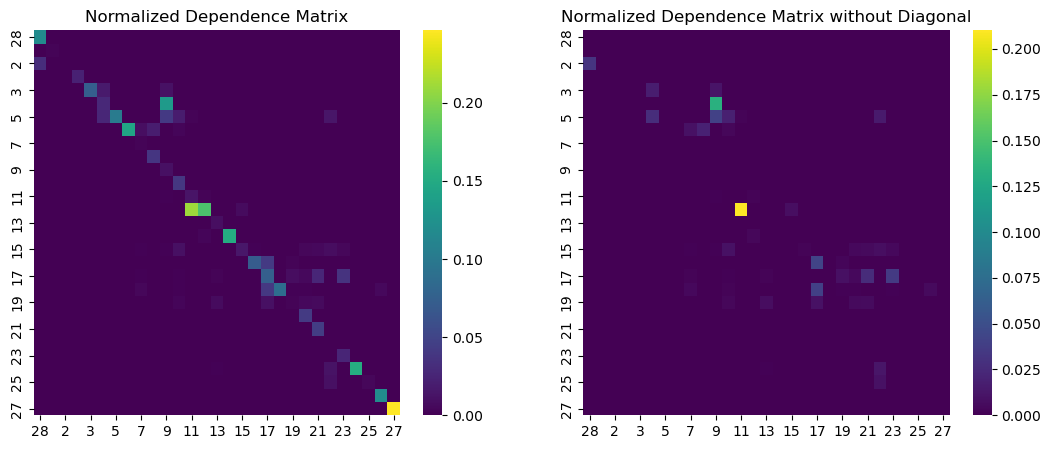

In [14]:
# normalize the result matrix by each column?
result_matrix_reindex_norm = result_matrix_reindex.reindex(columns=city_GDP.index)
# fill the diagonal with 0 and save as new matrix
result_matrix_reindex_norm_dia0 = result_matrix_reindex_norm.copy()
np.fill_diagonal(result_matrix_reindex_norm_dia0.values, 0)

#plot a subplots with two heatmaps with and without diagonal
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(result_matrix_reindex_norm, ax=axs[0], cmap='viridis')
axs[0].set_title('Normalized Dependence Matrix')
sns.heatmap(result_matrix_reindex_norm_dia0, ax=axs[1], cmap='viridis')
axs[1].set_title('Normalized Dependence Matrix without Diagonal')
plt.show()

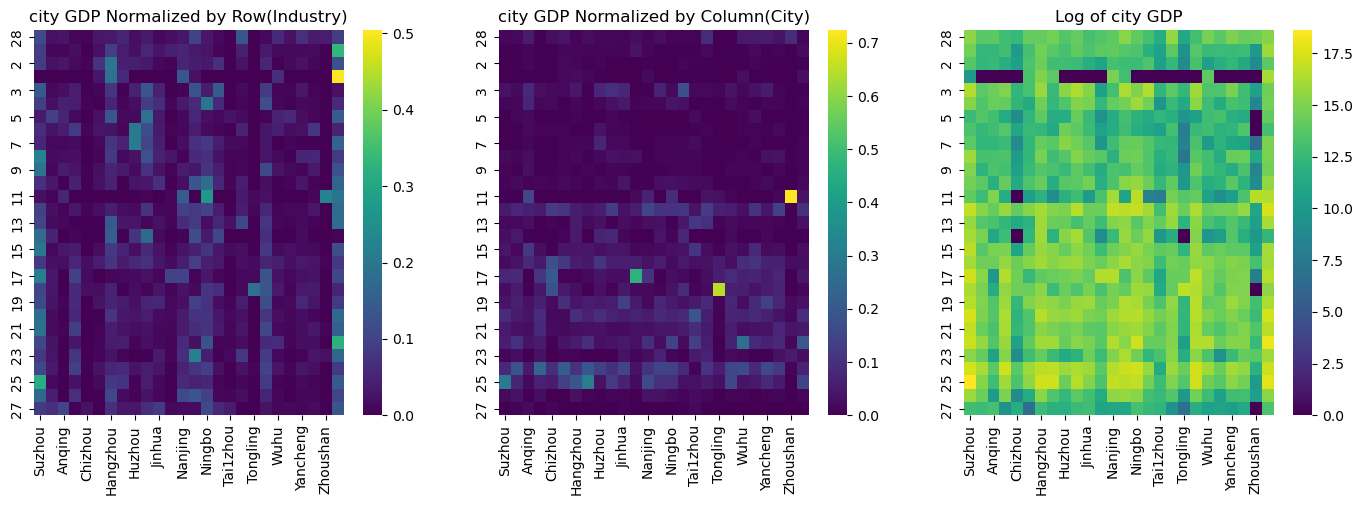

In [15]:
# normalize the city_GDP by each row
city_GDP_norm_row = city_GDP.div(city_GDP.sum(axis=1), axis=0)
city_GDP_norm_column = city_GDP.div(city_GDP.sum(axis=0), axis=1)
# take the log of the city GDP matrix
city_GDP_all_log = np.log(city_GDP + 1)

# plot the heatmap of the normalized city_GDP
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
sns.heatmap(city_GDP_norm_row, ax=axs[0], cmap='viridis')
axs[0].set_title('city GDP Normalized by Row(Industry)')
sns.heatmap(city_GDP_norm_column, ax=axs[1], cmap='viridis')
axs[1].set_title('city GDP Normalized by Column(City)')
sns.heatmap(city_GDP_all_log, ax=axs[2], cmap='viridis')
axs[2].set_title('Log of city GDP')
plt.show()

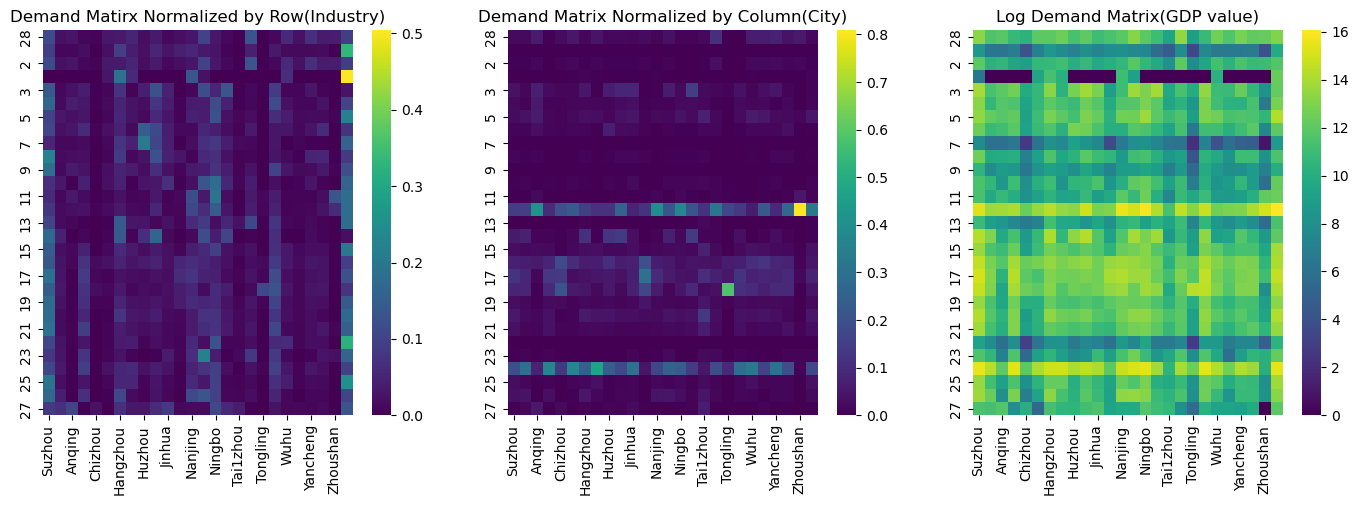

In [16]:
# left multiply the result matrix with the city matrix to get the demand matrix from each city's GDP to each industry
# this step, we could get how much demand each city have towards each industry in order to get their production
Demand_city_matrix_all = result_matrix_reindex_norm.dot(city_GDP * alpha)

# normalize the demand matrix by each row and column
Demand_norm_row = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=1), axis=0)
Demand_norm_column = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=0), axis=1)
# take the log of the demand matrix
Demand_city_matrix_all_log = np.log(Demand_city_matrix_all+1)

# plot the heatmap of the demand matrix
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
sns.heatmap(Demand_norm_row, ax=axs[0], cmap='viridis')
axs[0].set_title('Demand Matirx Normalized by Row(Industry)')
sns.heatmap(Demand_norm_column, ax=axs[1], cmap='viridis')
axs[1].set_title('Demand Matrix Normalized by Column(City)')
sns.heatmap(Demand_city_matrix_all_log, ax=axs[2], cmap='viridis')
axs[2].set_title('Log Demand Matrix(GDP value)')
plt.show()

### calculate the dependency relationship degree between the cities and the industries

In [17]:
# calculate the sum of each row in the city_GDP and save as an dictionary with index as the key
Provide_city_matrix_dict = city_GDP.sum(axis=1).to_dict()
Provide_city_matrix_sum = city_GDP.sum(axis=1)
#Provide_city_matrix_sum

In [18]:
Demand_city_sum_dict = Demand_city_matrix_all.sum(axis=1).to_dict()
Demand_city_sum = Demand_city_matrix_all.sum(axis=1)
#Demand_city_sum

In [19]:
diff = Provide_city_matrix_sum / Demand_city_sum
diff.head()

28      8.497536
1     435.641509
2       7.033276
29     43.455579
3      12.189268
dtype: float64

**Get the Interdependency Matrix**

In [20]:
# create a 26*26 matrix to store the dependency relationship between cities
city_list = city_GDP.columns

# create an empty city_dependency_matrix and set the data type to object
city_weighted_dependency_matrix = pd.DataFrame(index=city_list, columns=city_list, dtype=object)

# initialize each cell in the DataFrame to an empty list
for i in city_list:
    for j in city_list:
        city_weighted_dependency_matrix.loc[i, j] = []

#city_weighted_dependency_matrix

In [21]:
# calculate the proportion where city j's GDP contributes to city i's demand, means for each industry, how much will city i depend on city j
# and for each city pair, sum the weighted dependency for each industry
for i in city_list:
    for j in city_list:
        temp_dependency = city_GDP_norm_row.loc[:,j] * Demand_norm_row.loc[:, i] * Demand_city_matrix_all.loc[:, i] * city_GDP_norm_column.loc[:,i]
        temp_dependency = temp_dependency.fillna(0)
        # fill the infinities with the maximum value in the temp_dependency
        temp_dependency = temp_dependency.replace([np.inf, -np.inf], 0)
        #take the mean value of the temp_dependency as the dependency value
        depend_value = temp_dependency.sum()
        #depend_value = temp_dependency.sum()
        city_weighted_dependency_matrix.loc[i, j] = depend_value

Text(0.5, 1.0, 'Weighted Dependency Matrix')

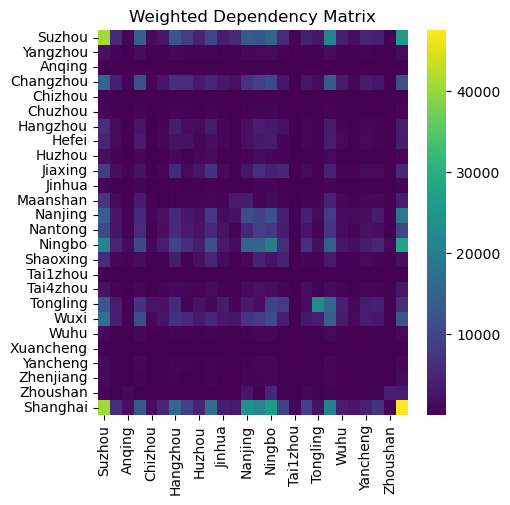

In [22]:
city_weighted_dependency_matrix = city_weighted_dependency_matrix.apply(pd.to_numeric, errors='coerce')
# take the logrithm of the weighted dependency matrix
#city_weighted_dependency_matrix_log = np.log(city_weighted_dependency_matrix + 1)
# plot the heatmap of the city_weighted_dependency_matrix
plt.figure(figsize=(5, 5))
sns.heatmap(city_weighted_dependency_matrix, cmap='viridis', cbar=True)
plt.title('Weighted Dependency Matrix')

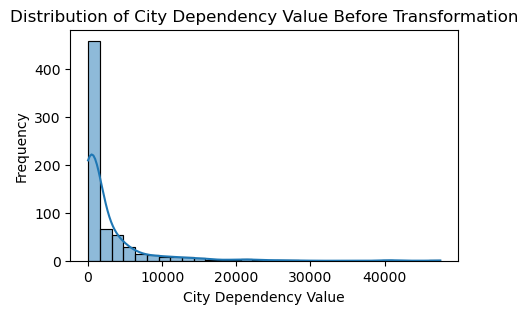

In [23]:
# plot the distribution of all the values in the adjacency_acc_df

plt.figure(figsize=(5, 3))
sns.histplot(city_weighted_dependency_matrix.values.flatten(), bins=30, kde=True)
plt.title('Distribution of City Dependency Value Before Transformation')
plt.xlabel('City Dependency Value')
plt.ylabel('Frequency')
plt.show()

In [24]:
#city_weighted_dependency_matrix_log = (city_weighted_dependency_matrix_log + city_weighted_dependency_matrix_log.T) / 2


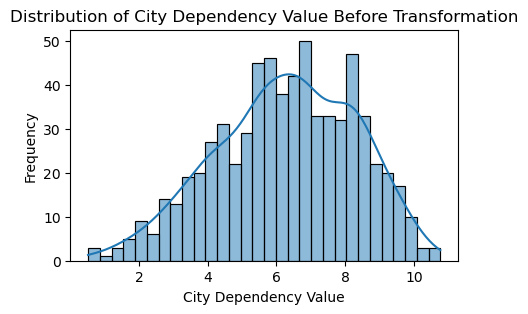

In [25]:


city_weighted_dependency_matrix_norm = np.log(city_weighted_dependency_matrix + 1)
plt.figure(figsize=(5, 3))
sns.histplot(city_weighted_dependency_matrix_norm.values.flatten(), bins=30, kde=True)
plt.title('Distribution of City Dependency Value Before Transformation')
plt.xlabel('City Dependency Value')
plt.ylabel('Frequency')
plt.show()

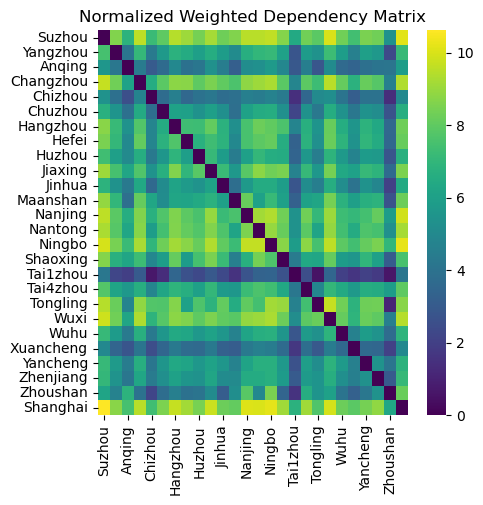

In [26]:
city_weighted_dependency_matrix_norm_2 = city_weighted_dependency_matrix_norm.copy()
# set the diagonal of the matrix to 0
np.fill_diagonal(city_weighted_dependency_matrix_norm_2.values, 0)
# plot the heatmap of the city_weighted_dependency_matrix
plt.figure(figsize=(5, 5))
sns.heatmap(city_weighted_dependency_matrix_norm_2, cmap="viridis", cbar=True)
plt.title('Normalized Weighted Dependency Matrix')
plt.show()


In [27]:
# check if the matrix 'city_weighted_dependency_matrix_norm_2' is symmetric
(city_weighted_dependency_matrix_norm == city_weighted_dependency_matrix_norm.T).all().all()

False

In [28]:
"""
# convert the city_weighted_dependency_matrix to a numpy array
city_weighted_dependency_matrix_array = city_weighted_dependency_matrix_norm.to_numpy()
# calculate the mean and standard deviation of the array
mean_val = city_weighted_dependency_matrix_array.mean()
std_val = city_weighted_dependency_matrix_array.std()
print(mean_val)
print(std_val)
# 进行 Z-score 归一化
city_weighted_dependency_matrix_norm = (city_weighted_dependency_matrix_norm - mean_val) / std_val
# take the exponential of the normalized matrix
city_weighted_dependency_matrix_norm = np.exp(city_weighted_dependency_matrix_norm)


plt.figure(figsize=(5, 3))
sns.histplot(city_weighted_dependency_matrix_norm.values.flatten(), bins=30, kde=True)
plt.title('Distribution of City Dependency Value Before Transformation')
plt.xlabel('City Dependency Value')
plt.ylabel('Frequency')
plt.show()
"""

"\n# convert the city_weighted_dependency_matrix to a numpy array\ncity_weighted_dependency_matrix_array = city_weighted_dependency_matrix_norm.to_numpy()\n# calculate the mean and standard deviation of the array\nmean_val = city_weighted_dependency_matrix_array.mean()\nstd_val = city_weighted_dependency_matrix_array.std()\nprint(mean_val)\nprint(std_val)\n# 进行 Z-score 归一化\ncity_weighted_dependency_matrix_norm = (city_weighted_dependency_matrix_norm - mean_val) / std_val\n# take the exponential of the normalized matrix\ncity_weighted_dependency_matrix_norm = np.exp(city_weighted_dependency_matrix_norm)\n\n\nplt.figure(figsize=(5, 3))\nsns.histplot(city_weighted_dependency_matrix_norm.values.flatten(), bins=30, kde=True)\nplt.title('Distribution of City Dependency Value Before Transformation')\nplt.xlabel('City Dependency Value')\nplt.ylabel('Frequency')\nplt.show()\n"

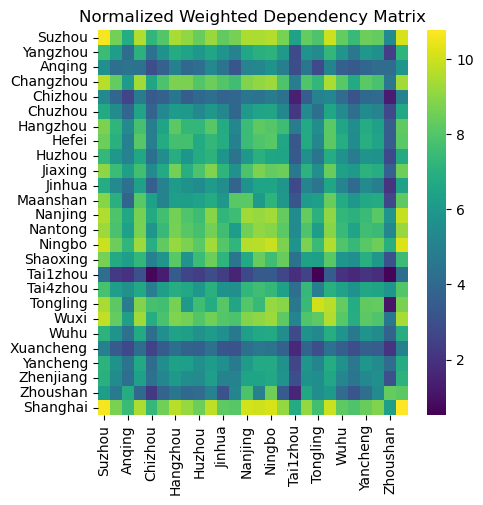

In [29]:


# plot the heatmap of the city_weighted_dependency_matrix
plt.figure(figsize=(5, 5))
sns.heatmap(city_weighted_dependency_matrix_norm, cmap="viridis", cbar=True)
plt.title('Normalized Weighted Dependency Matrix')
plt.show()


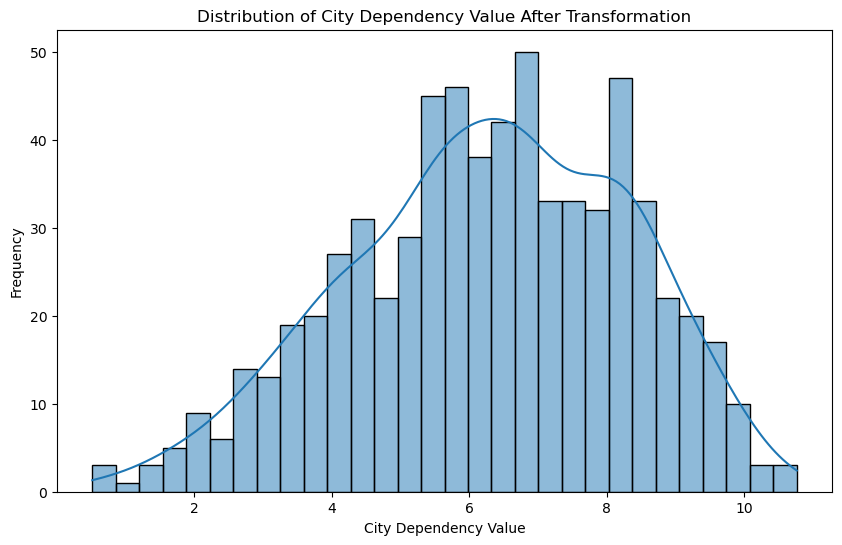

In [30]:

# plot the distribution of all the values in the adjacency_acc _df
plt.figure(figsize=(10, 6))
sns.histplot(city_weighted_dependency_matrix_norm.values.flatten(), bins=30, kde=True)
plt.title('Distribution of City Dependency Value After Transformation')
plt.xlabel('City Dependency Value')
plt.ylabel('Frequency')
plt.show()


### construct the supply chain network based on the input-output table and the dependency relationship degree

In [31]:
#download the city's coordinates from the OpenStreetMap
# construct the city'list for its specific name in OSM
city_namelist_OSM = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 '滁州市','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']
city_namelist_OSM_en = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 'Chuzhou, Anhui, China','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']

# download each city's osmid and save it into a list
city_osmid = []

for city_name in city_namelist_OSM:
    try:
        # get the city's geographic data
        gdf = ox.geocode_to_gdf(city_name)
        city_osmid.append(gdf.osm_id.iloc[0])
    except Exception as e:
        print(f"Error retrieving data for {city_name}: {e}")


In [32]:
len(city_osmid)

26

In [33]:
# download each city's boundary data and center's coordinates data
city_centers = {}

# Iterate over the list of cities to get the boundary and center coordinates of each city
for i in range(len(city_osmid)):
    try:
        # get the city's geographic data
        gdf = ox.geocode_to_gdf(f"R{city_osmid[i]}", by_osmid=True)
        
        # convert the geographic data to the Web Mercator projection
        gdf_projected = gdf.to_crs(epsg=4326)
        
        # get the center of the city coordinates
        center = gdf_projected.geometry.centroid.iloc[0]
        
        # save the city's center coordinates to a dict
        city_centers[city_namelist_OSM_en[i]] = (center.x, center.y)
        
 
    except Exception as e:
        print(f"Error retrieving data for {city_namelist_OSM_en[i]}: {e}")

C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\3275564664.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf_projected.geometry.centroid.iloc[0]
C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\3275564664.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf_projected.geometry.centroid.iloc[0]
C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\3275564664.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf_projected.geometry.centroid.iloc[0]
C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\3275564664.py:14: UserWarning: Geometry is in a ge

In [34]:
# read the city boundary shapefile
city_boundary = gpd.read_file('Data/python/Area_boundary.shp')

In [35]:
# change the index and columns name of combined_dependency_matrix into 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25, 
# and save it into a new DataFrame called 'edge_matrix'
edge_matrix = city_weighted_dependency_matrix_norm.copy()
edge_matrix.index = range(26)
edge_matrix.columns = range(26)
# convert the edge_matrix to a symmetric matrix, by taking the mean value of the two values in the matrix
#edge_matrix = (edge_matrix + edge_matrix.T) / 2


In [36]:
# check if edge_matrix is symmetric
(edge_matrix == edge_matrix.T).all().all()

False

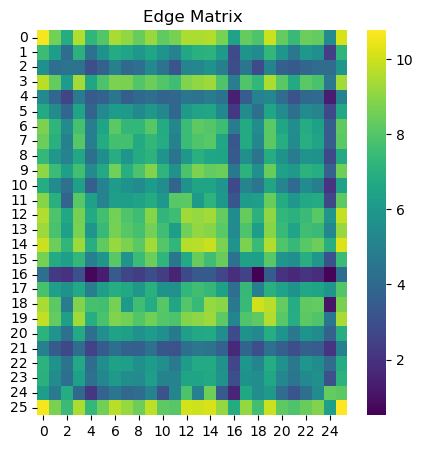

In [37]:
#plot the heatmap of the edge_matrix
plt.figure(figsize=(5, 5))
sns.heatmap(edge_matrix, cmap='viridis', cbar=True)
plt.title('Edge Matrix')
plt.show()

**Some intensional process about edge matrix**

In [38]:
# set the diagonal elements of the distance matrix to 0
np.fill_diagonal(edge_matrix.values, 0)

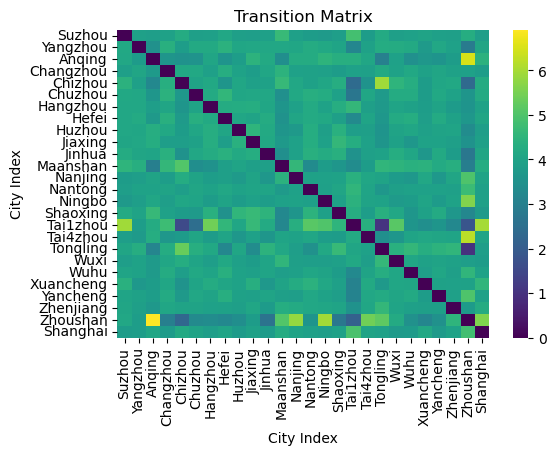

In [39]:
Transition_matrix = edge_matrix.copy()
# normalize the Transition_matrix by each column
Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=0), axis=1)
# normalize the Transition_matrix by each row
Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=1), axis=0)

Transition_matrix = Transition_matrix * 100
#plot a heatmap of the transition matrix
plt.figure(figsize=(6, 4))
sns.heatmap(Transition_matrix, cmap="viridis", cbar=True)
plt.title('Transition Matrix')
plt.xlabel('City Index')
plt.ylabel('City Index')
# use the columns of the city_weighted_dependency_matrix as the xticks, and tick should be in the center of the cell
plt.xticks(ticks=np.arange(26) + 0.5, labels=city_weighted_dependency_matrix.columns, rotation=90)
# use the columns of the city_weighted_dependency_matrix as the yticks
plt.yticks(ticks=np.arange(26) + 0.5, labels=city_weighted_dependency_matrix.columns, rotation=0)
plt.show()

In [40]:
# 改成对称矩阵
#Transition_matrix = (Transition_matrix + Transition_matrix.T) / 2

#Transition_matrix = np.exp(Transition_matrix)
Transition_matrix = Transition_matrix.apply(pd.to_numeric)

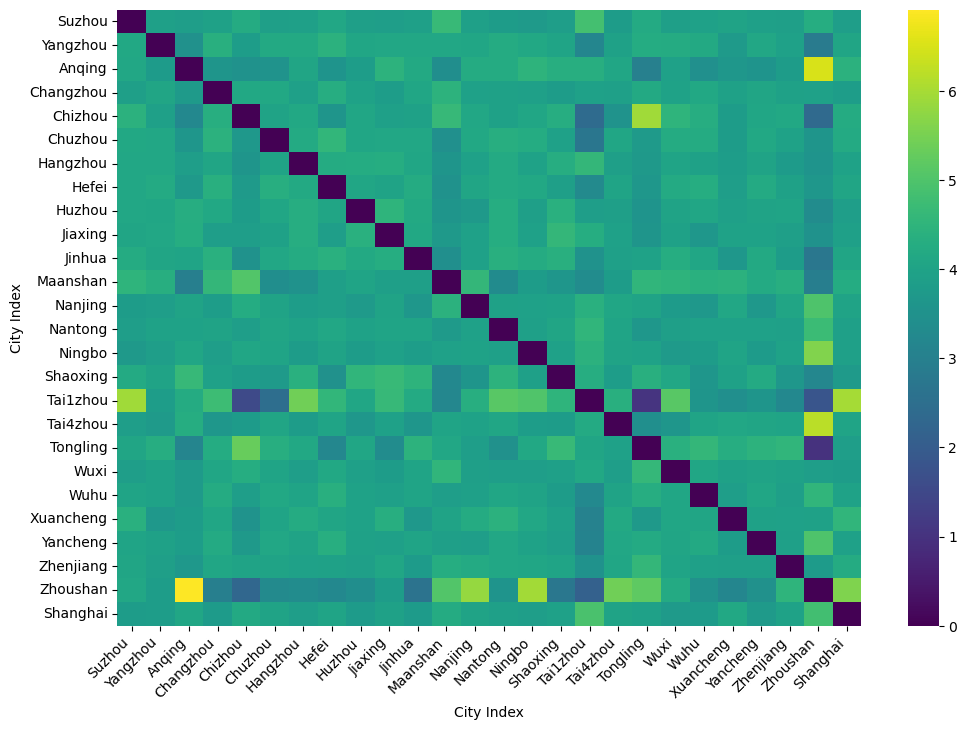

In [41]:
#plot a heatmap of the transition matrix
plt.figure(figsize=(12, 8))
sns.heatmap(Transition_matrix, cmap="viridis", cbar=True)
#plt.title('Manufacture Dependency Adjacency Matrix')
plt.xlabel('City Index')
plt.ylabel('City Index')
# use the columns of the city_weighted_dependency_matrix as the xticks, and tick should be in the center of the cell
plt.xticks(ticks=np.arange(26) + 0.5, labels=city_weighted_dependency_matrix.columns, rotation=45, ha='right')
# use the columns of the city_weighted_dependency_matrix as the yticks
plt.yticks(ticks=np.arange(26) + 0.5, labels=city_weighted_dependency_matrix.columns, rotation=0)
plt.show()

In [42]:
# 保留每一行的最大n个值，其余位置改为0
def retain_top_n_per_row(matrix, n):
    matrix_copy = matrix.copy()
    for index, row in matrix_copy.iterrows():
        top_n_indices = row.nlargest(n).index
        row[:] = [value if col in top_n_indices else 0 for col, value in row.items()]
    return matrix_copy

# 保留每一列的最大n个值，其余位置改为0
def retain_top_n_per_col(matrix, n):
    matrix_copy = matrix.copy()
    for col in matrix_copy.columns:
        top_n_indices = matrix_copy[col].nlargest(n).index
        matrix_copy[col] = [value if idx in top_n_indices else 0 for idx, value in matrix_copy[col].items()]
    return matrix_copy

In [43]:

# 获取A1和A2
A1 = retain_top_n_per_row(Transition_matrix, cut_num)
A2 = retain_top_n_per_col(Transition_matrix, cut_num)

# 将A1和A2合并，选取每个位置较大的值
Transition_matrix_cut = pd.DataFrame(np.maximum(A1, A2), index=Transition_matrix.index, columns=Transition_matrix.columns)
#Transition_matrix_cut

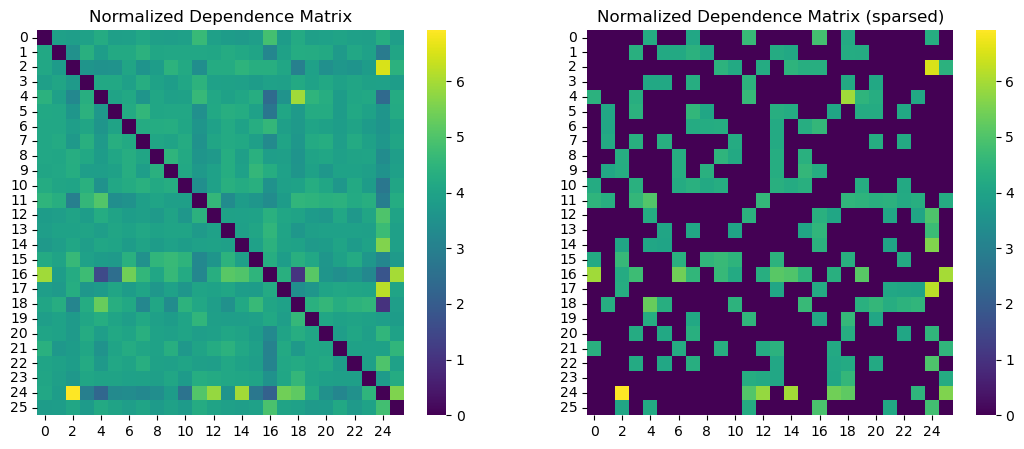

In [44]:
#plot a subplots with two heatmaps with and without diagonal
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(Transition_matrix, ax=axs[0], cmap='viridis')
axs[0].set_title('Normalized Dependence Matrix')
sns.heatmap(Transition_matrix_cut, ax=axs[1], cmap="viridis", cbar=True)
axs[1].set_title('Normalized Dependence Matrix (sparsed)')
plt.show()

In [45]:
# calculate the mean and standard deviation of the Transition_matrix
mean_val = Transition_matrix.mean().mean()
std_val = Transition_matrix.std().std()
# take the z-score noramlization of the Transition_matrix
Transition_matrix = (Transition_matrix - mean_val) / std_val
# take the exponential of the z-score normalized matrix
Transition_matrix = Transition_matrix / 10
Transition_matrix = np.exp(Transition_matrix)

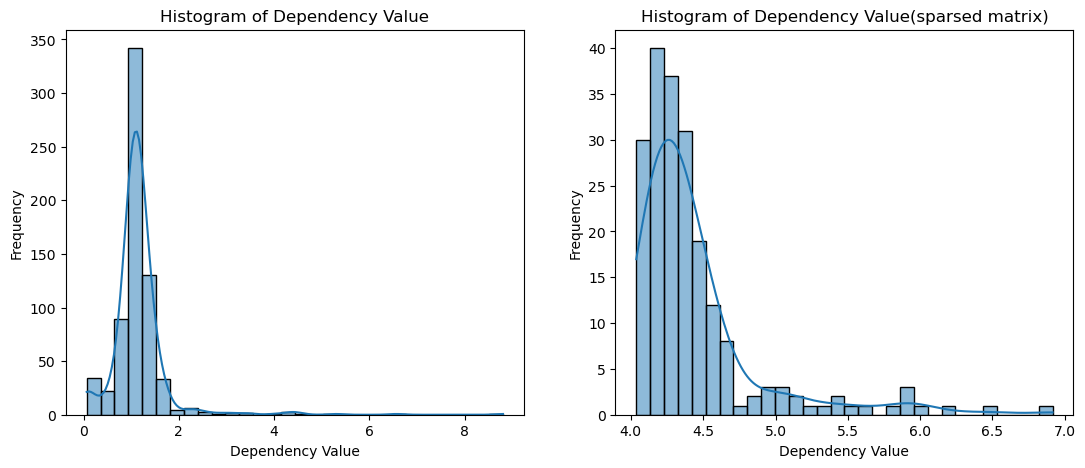

In [46]:
Transition_matrix_nonzero = Transition_matrix.values.flatten()
Transition_matrix_nonzero = Transition_matrix_nonzero[Transition_matrix_nonzero != 0]
# remove all the 0 values in the edge matrix
Transition_matrix_cut_nonzero = Transition_matrix_cut.values.flatten()
Transition_matrix_cut_nonzero = Transition_matrix_cut_nonzero[Transition_matrix_cut_nonzero != 0]

# plot the histogram of all values in the edge matrix, after remove all the 0 values
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.histplot(Transition_matrix_nonzero, ax=axs[0], bins=30, kde=True)
axs[0].set_title('Histogram of Dependency Value')
axs[0].set_xlabel('Dependency Value')
axs[0].set_ylabel('Frequency')
sns.histplot(Transition_matrix_cut_nonzero, ax=axs[1], bins=30, kde=True)
axs[1].set_title('Histogram of Dependency Value(sparsed matrix)')
axs[1].set_xlabel('Dependency Value')
axs[1].set_ylabel('Frequency')
plt.show()

In [47]:
# check the proportion of the 0 values in the transition matrix
Transition_matrix_cut_zero = Transition_matrix_cut.values.flatten()
Transition_matrix_cut_zero = Transition_matrix_cut_zero[Transition_matrix_cut_zero == 0]
Transition_matrix_cut_zero.shape[0] / Transition_matrix_cut.values.flatten().shape[0]
# print the proportion of the 0 values in the transition matrix
print(f"Proportion of non-0 values in the transition matrix: {1-Transition_matrix_cut_zero.shape[0] / Transition_matrix.values.flatten().shape[0]}")
# print the number of non-zero values in the transition matrix and the total number of values in the transition matrix
print(f"Number of non-zero values in the transition matrix: {Transition_matrix_cut.values.flatten().shape[0] - Transition_matrix_cut_zero.shape[0]}")
print(f"Total number of values in the transition matrix: {Transition_matrix_cut.values.flatten().shape[0]}")
print(f"cut_num: {cut_num}")

Proportion of non-0 values in the transition matrix: 0.29881656804733725
Number of non-zero values in the transition matrix: 202
Total number of values in the transition matrix: 676
cut_num: 6


In [48]:
# create the raw directed graph
G_raw = nx.DiGraph()

# add the nodes to the network
for city_name, coords in city_centers.items():
    G_raw.add_node(city_name, pos=coords)


# add the edges and weights to the network
for i, city1 in enumerate(city_namelist_OSM_en):
    for j, city2 in enumerate(city_namelist_OSM_en):
        if i != j: 
            # check the weight of the edge between city1 and city2, if it is 0
            # then do not add the edge to the network
            weight_ij = Transition_matrix.iloc[i, j]
            weight_ji = Transition_matrix.iloc[j, i]
            if weight_ij != 0:
                G_raw.add_edge(city1, city2, weight=weight_ij)

# 手动设置图的 CRS 属性
G_raw.graph['crs'] = 'EPSG:4326'

# create a undirected graph
G_cut = G_raw.copy()


In [49]:
# create the raw undirected graph
G_raw2 = nx.Graph()

# add the nodes to the network
for city_name, coords in city_centers.items():
    G_raw2.add_node(city_name, pos=coords)


# add the edges and weights to the network
for i, city1 in enumerate(city_namelist_OSM_en):
    for j, city2 in enumerate(city_namelist_OSM_en):
        if i != j: 
            # check the weight of the edge between city1 and city2, if it is 0
            # then do not add the edge to the network
            weight_ij = Transition_matrix.iloc[i, j]
            weight_ji = Transition_matrix.iloc[j, i]
            if weight_ij != 0 and weight_ij == weight_ji:
                G_raw2.add_edge(city1, city2, weight=weight_ij)

# 手动设置图的 CRS 属性
G_raw2.graph['crs'] = 'EPSG:4326'


In [50]:
# 查看 gdf 的坐标参考系
city_boundary_crs = city_boundary.crs
print("gdf CRS:", city_boundary_crs)

gdf CRS: EPSG:4326


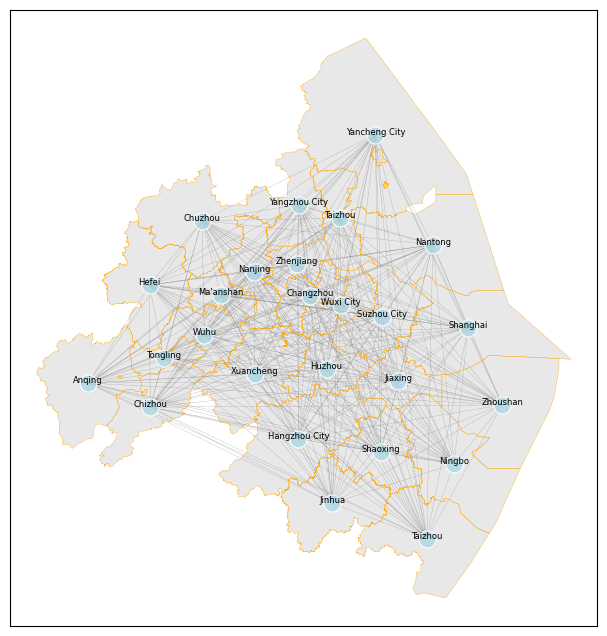

In [51]:
# get the node positions
pos = nx.get_node_attributes(G_raw, 'pos')


# plot the nodes
fig, ax = plt.subplots(figsize=(12, 8))

# plot the boundary of gdf
city_boundary.boundary.plot(ax=ax, edgecolor='orange', linewidth=0.25, alpha=1)

# label the city name, set the font size to 5
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# fill the boundary with a color
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)

# plot the nodes
nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# plot the edges
nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color='gray', width=0.1, style='dashed', arrows=False)

# plot the edge labels (optional)
# nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)

plt.show()

In [52]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

In [53]:
G_raw.edges(data=True)


OutEdgeDataView([('Suzhou City, Jiangsu, China', 'Yangzhou City, Jiangsu, China', {'weight': 1.0318268110016293}), ('Suzhou City, Jiangsu, China', 'Anqing, Anhui, China', {'weight': 1.003699505899902}), ('Suzhou City, Jiangsu, China', 'Changzhou, Jiangsu, China', {'weight': 1.0763296197910837}), ('Suzhou City, Jiangsu, China', 'Chizhou, Anhui, China', {'weight': 1.3137013055445323}), ('Suzhou City, Jiangsu, China', 'Chuzhou, Anhui, China', {'weight': 1.0274967912335007}), ('Suzhou City, Jiangsu, China', 'Hangzhou City, Zhejiang, China', {'weight': 1.035580240281633}), ('Suzhou City, Jiangsu, China', 'Hefei, Anhui, China', {'weight': 1.218784906989285}), ('Suzhou City, Jiangsu, China', 'Huzhou, Zhejiang, China', {'weight': 1.0198202690681488}), ('Suzhou City, Jiangsu, China', 'Jiaxing, Zhejiang, China', {'weight': 1.0013978432686548}), ('Suzhou City, Jiangsu, China', 'Jinhua, Zhejiang, China', {'weight': 1.0488429084497612}), ('Suzhou City, Jiangsu, China', "Ma'anshan, Anhui, China", {'

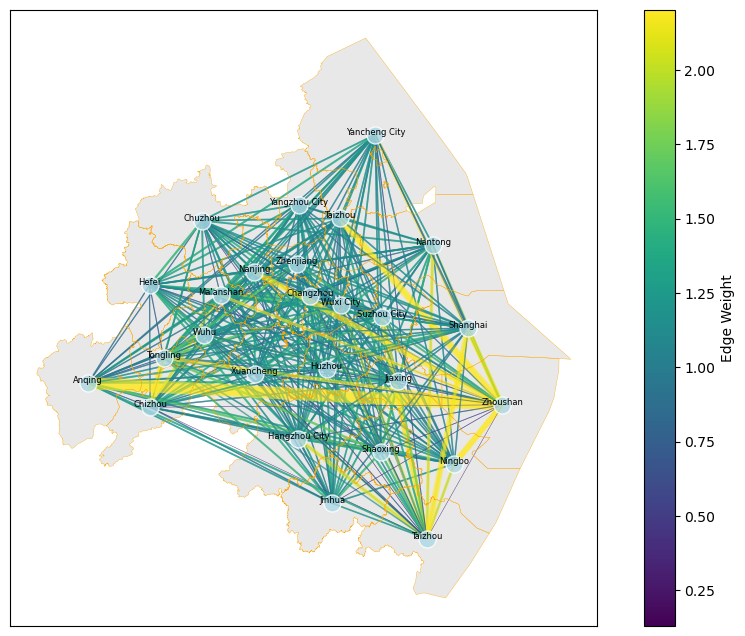

In [54]:
# get the node positions
pos = nx.get_node_attributes(G_raw, 'pos')

# Plot the nodes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the boundary of gdf
city_boundary.boundary.plot(ax=ax, edgecolor='orange', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 5
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# Fill the boundary with a color
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)

# Calculate the weights and determine the new vmax
weights = [data['weight'] for u, v, data in G_raw.edges(data=True)]
new_vmax = max(weights) / 4

# Normalize the weights using the new vmax
norm = Normalize(vmin=min(weights), vmax=new_vmax)

# Create a ScalarMappable object with the colormap
sm = ScalarMappable(cmap='viridis', norm=norm)

# Plot the edges with the modified color mapping
edge_colors = []
for u, v, data in G_raw.edges(data=True):
    weight = data['weight']
    if weight > new_vmax:
        edge_colors.append(sm.to_rgba(new_vmax))  # Use the color corresponding to new_vmax
    else:
        edge_colors.append(sm.to_rgba(weight))    # Use the normal color mapping

nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color=edge_colors, width=[data['weight'] for u, v, data in G_raw.edges(data=True)], arrows=False, alpha=0.6)

# Plot the nodes
nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# Add a colorbar to the plot
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Weight')

plt.show()

### Community Detection

In [55]:
import networkx as nx
import numpy as np
import cvxpy as cp


In [56]:
type(Transition_matrix)

pandas.core.frame.DataFrame

In [57]:
def weighted_degree_assortativity_coefficient(G):
    """Calculate the weighted degree assortativity coefficient of a graph.
    """
    # get all the edges and their weights
    edges = G.edges(data=True)
    
    # calculate the weighted degree of each node
    weighted_degrees = {}
    for u, v, data in edges:
        weighted_degrees[u] = weighted_degrees.get(u, 0) + data.get('weight', 1)
        weighted_degrees[v] = weighted_degrees.get(v, 0) + data.get('weight', 1)
    
    # construct a list of weighted degree pairs containing all edges
    weighted_degree_pairs = [(weighted_degrees[u], weighted_degrees[v]) for u, v, data in edges]
    
    if not weighted_degree_pairs:
        return float('nan')

    # convert to a numpy array
    weighted_degree_pairs = np.array(weighted_degree_pairs)
    
    # get the mean values of the weighted degree pairs
    x_mean = np.mean(weighted_degree_pairs[:, 0])
    y_mean = np.mean(weighted_degree_pairs[:, 1])
    
    # get the numerator of the weighted assortativity
    numerator = np.sum((weighted_degree_pairs[:, 0] - x_mean) * (weighted_degree_pairs[:, 1] - y_mean))
    
    # get the denominator of the weighted assortativity
    denominator = np.sqrt(
        np.sum((weighted_degree_pairs[:, 0] - x_mean) ** 2) *
        np.sum((weighted_degree_pairs[:, 1] - y_mean) ** 2)
    )
    
    # return the weighted assortativity coefficient
    if denominator == 0:
        return float('nan')
    
    return numerator / denominator

weighted_assortativity = weighted_degree_assortativity_coefficient(G_raw)
print(f"Weighted degree assortativity coefficient: {weighted_assortativity}")

Weighted degree assortativity coefficient: -0.039999999999999994


**Use the simple community detection method**

c:\Users\SBH\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


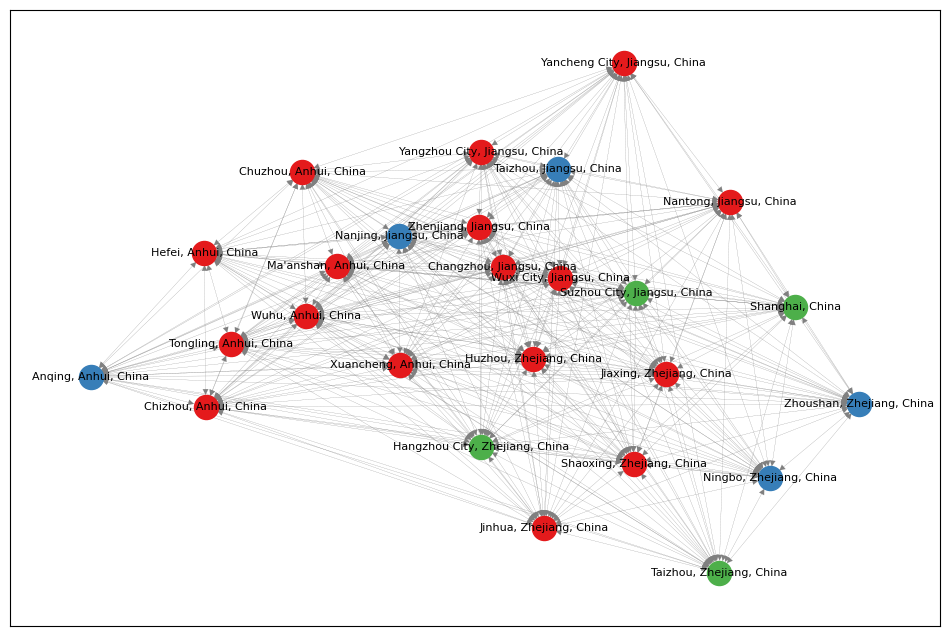

In [58]:
# run the community detection to the graph G
communities_GMC = nx.community.greedy_modularity_communities(G_raw, weight='weight', resolution=1.0)

# save the communities to the G_raw graph, as a attribute for each node
for i, community in enumerate(communities_GMC):
    for node in community:
        G_raw.nodes[node]['community_GreedyModularity'] = i

# print the graph with different colors for each community, and add the legends
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set1', len(communities_GMC))
for i, community in enumerate(communities_GMC):
    nx.draw_networkx_nodes(G_raw, pos, nodelist=community, node_color=colors[i], node_size=300)
nx.draw_networkx_edges(G_raw, pos, edge_color='gray', width=0.1, style='dashed')
nx.draw_networkx_labels(G_raw, pos, font_size=8)
plt.show()

In [59]:
# create a dataframe based on the communities_GMC, the columns will be the communities_id, which values are 0, 1, 2, 3, 4,  or 5
# and the elements in the same frozenset will share the same value for the community_id, from 0 to 5
community_df = pd.DataFrame(index=city_namelist_OSM_en, columns=['community_GMC_id_8'])
for i, community in enumerate(communities_GMC):
    for node in community:
        community_df.loc[node, 'community_GMC_id_8'] = i
community_df.sample(3)

community_GMC_id_8
Shanghai, China                            2
Shaoxing, Zhejiang, China                  0
Zhenjiang, Jiangsu, China                  0

C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\737036924.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_communities))


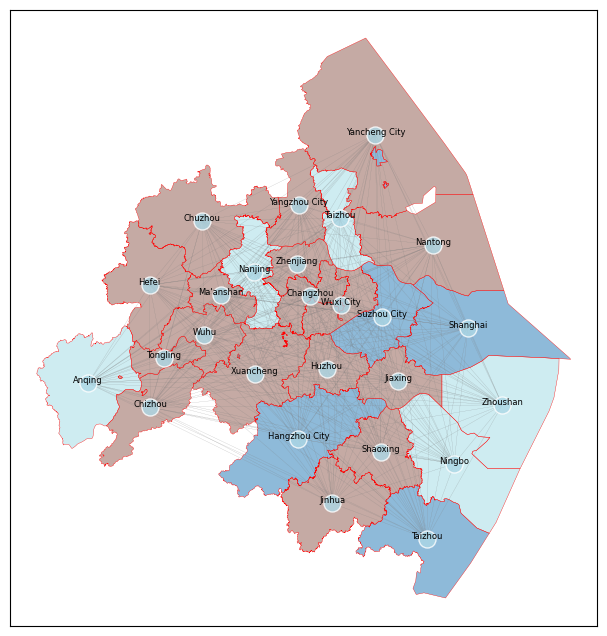

In [60]:
city_boundary = city_boundary.merge(community_df[['community_GMC_id_8']], left_on='display_na', right_index=True, how='left')
city_boundary.sample(1)
# 生成颜色映射
unique_communities = community_df['community_GMC_id_8'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['community_GMC_id_8'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_raw, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color='gray', width=0.1, arrows=False, alpha=0.5)
plt.show()

In [61]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralBiclustering
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

A = nx.adjacency_matrix(G_raw).astype(float)
D = np.diag(np.array(A.sum(axis=1)).flatten())
L = D - A

# 计算拉普拉斯矩阵的前 k 个特征值和特征向量
k = 8  # 假设我们想要嵌入到 5 维空间
vals, vecs = eigs(L, k=k, which='SM')
vecs = vecs.real

# 使用 SpectralBiclustering 进行双聚类
biclustering = SpectralBiclustering(n_clusters=k)
biclustering.fit(vecs)
labels_bicluster = biclustering.row_labels_

# 打印每个节点的社区标签
print(labels_bicluster)


c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with M

[4 4 2 1 1 7 2 7 3 3 2 1 4 7 7 3 7 7 4 5 0 0 0 6 7 7]


c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment

c:\Users\SBH\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


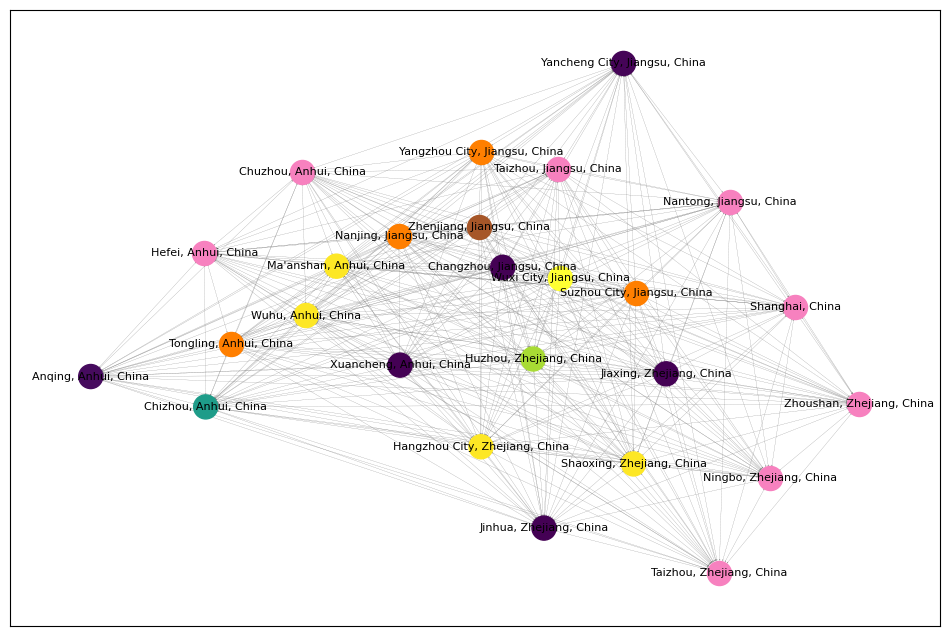

In [62]:
# save the communities to the G_raw graph, as a attribute for each node
for i, node in enumerate(G_raw.nodes()):
    G_raw.nodes[node]['community_SpectralClustering'] = labels_bicluster[i]

# print the graph with different colors for each community, and add the legends
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set1', 8)
for i in range(8):
    community = [node for node in G_raw.nodes() if G_raw.nodes[node]['community_SpectralClustering'] == i]
    nx.draw_networkx_nodes(G_raw, pos, nodelist=community, node_color=colors[i], node_size=300)
nx.draw_networkx_edges(G_raw, pos, edge_color='gray', width=0.1, style='dashed', arrowsize=2)
nx.draw_networkx_labels(G_raw, pos, font_size=8)
plt.show()

In [63]:
# add the labels_bicluster's value to the community_df as a new column "community_Bicluster_id_8"
community_df['community_Bicluster_id_8'] = labels_bicluster
community_df.sample(3)

community_GMC_id_8  community_Bicluster_id_8
Hefei, Anhui, China                          0                         7
Suzhou City, Jiangsu, China                  2                         4
Ningbo, Zhejiang, China                      1                         7

C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\2825121090.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_communities))


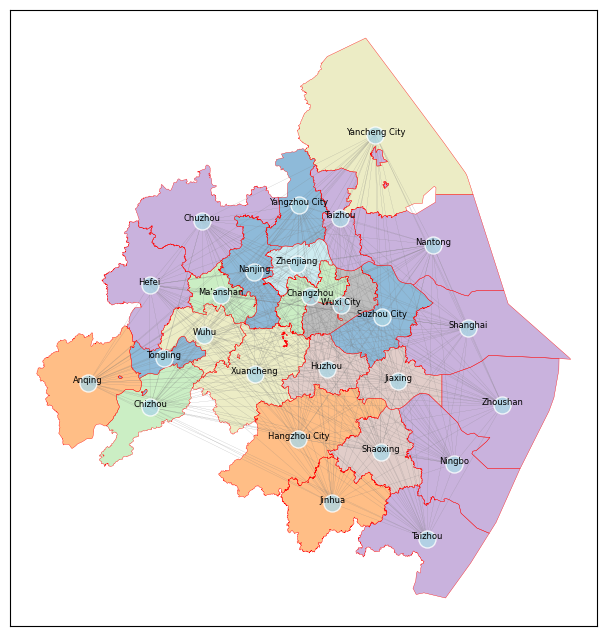

In [64]:
city_boundary = city_boundary.merge(community_df[['community_Bicluster_id_8']], left_on='display_na', right_index=True, how='left')
city_boundary.sample(1)
# 生成颜色映射
unique_communities = community_df['community_Bicluster_id_8'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['community_Bicluster_id_8'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_raw, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color='gray', width=0.1, arrows=False, alpha=0.5)
plt.show()

In [65]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs


def spectral_clustering(G, k):
    # 构建拉普拉斯矩阵
    A = nx.adjacency_matrix(G).astype(float)
    D = np.diag(np.array(A.sum(axis=1)).flatten())
    L = D - A

    # 计算前k个最小特征值对应的特征向量
    vals, vecs = eigs(L, k=k, which='SM')
    vecs = vecs.real

    # 使用K-means进行聚类
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs)
    labels = kmeans.labels_

    return labels


c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SBH\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


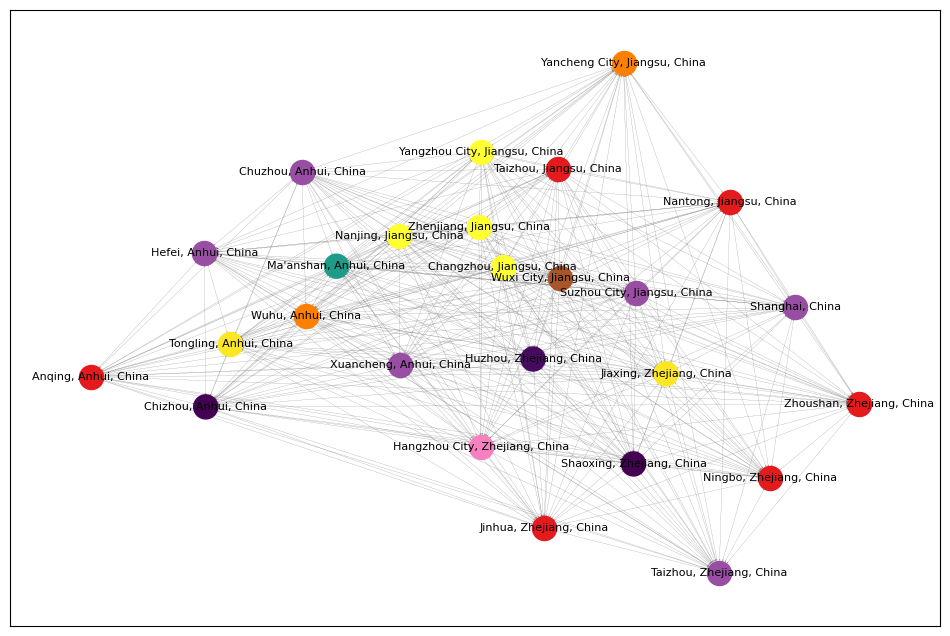

In [66]:

# 进行谱聚类，假设聚为8个社区
labels_spectral = spectral_clustering(G_raw, 8)

# save the communities to the G_raw graph, as a attribute for each node
for i, node in enumerate(G_raw.nodes()):
    G_raw.nodes[node]['community_SpectralClustering'] = labels_spectral[i]

# print the graph with different colors for each community, and add the legends
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set1', 8)
for i in range(8):
    community = [node for node in G_raw.nodes() if G_raw.nodes[node]['community_SpectralClustering'] == i]
    nx.draw_networkx_nodes(G_raw, pos, nodelist=community, node_color=colors[i], node_size=300)
nx.draw_networkx_edges(G_raw, pos, edge_color='gray', width=0.1, style='dashed', arrowsize=2)
nx.draw_networkx_labels(G_raw, pos, font_size=8)
plt.show()

In [67]:
community_df['community_Spectral_id_8'] = labels_spectral
community_df.sample(3)

community_GMC_id_8  community_Bicluster_id_8  \
Yangzhou City, Jiangsu, China                  0                         4   
Jiaxing, Zhejiang, China                       0                         3   
Huzhou, Zhejiang, China                        0                         3   

                               community_Spectral_id_8  
Yangzhou City, Jiangsu, China                        5  
Jiaxing, Zhejiang, China                             2  
Huzhou, Zhejiang, China                              2

C:\Users\SBH\AppData\Local\Temp\ipykernel_2364\1535725495.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_communities))


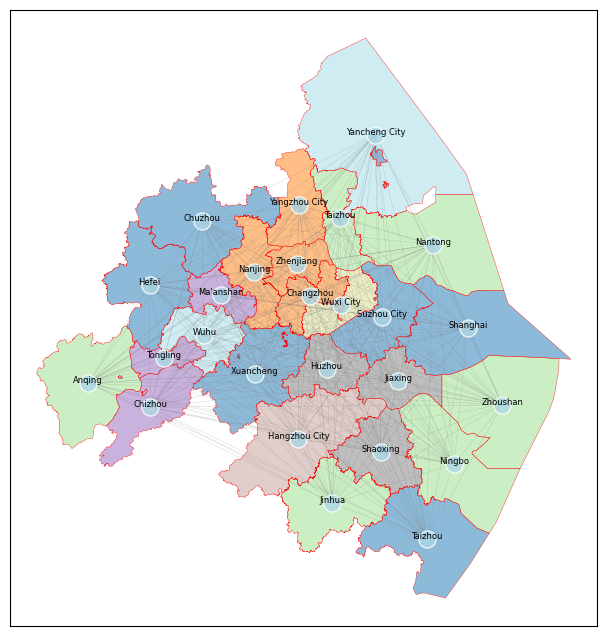

In [68]:
city_boundary = city_boundary.merge(community_df[['community_Spectral_id_8']], left_on='display_na', right_index=True, how='left')
city_boundary.sample(1)
# 生成颜色映射
unique_communities = community_df['community_Spectral_id_8'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['community_Spectral_id_8'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_raw, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color='gray', width=0.1, arrows=False, alpha=0.5)
plt.show()

#### Markov Stability

In [69]:
import numpy as np
import pandas as pd
import networkx as nx
import pygenstability as pgs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import shortest_path
from pygenstability import plotting

In [70]:
adjacency_raw = nx.to_numpy_array(G_raw)
adjacency_cut = nx.to_numpy_array(G_cut)

In [74]:
all_results = pgs.run(sp.sparse.csgraph.csgraph_from_dense(adjacency_raw), constructor='linearized_directed', 
                    min_scale=-2, max_scale=2, n_scale=200, method='leiden', n_workers=8,
                    log_scale=True, n_tries=800, n_NVI=20, with_spectral_gap=False)

Your graph is directed!


100%|██████████| 200/200 [00:01<00:00, 122.18it/s]


In [75]:
# check the number of each value in the number_of_communities
number_of_communities = all_results['number_of_communities']
number_of_communities = pd.Series(number_of_communities)
number_of_communities.value_counts()


26    114
1      86
Name: count, dtype: int64

In [73]:
number_of_communities_dict = number_of_communities.value_counts().to_dict()
number_of_communities_dict

{26: 286, 1: 214}

In [203]:

pgs.plot_scan(all_results, scale_axis=True,
    figure_name="scan_results_eco_raw2.pdf",
    use_plotly=False,
    live=False,
    plotly_filename="Results/scan_results_eco_raw.html")


[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>]

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x480 with 6 Axes>

In [136]:
# get the 127th element in the scales list
all_results['scales'][260]

1.2138592626906277

In [284]:
#all_results['stability']

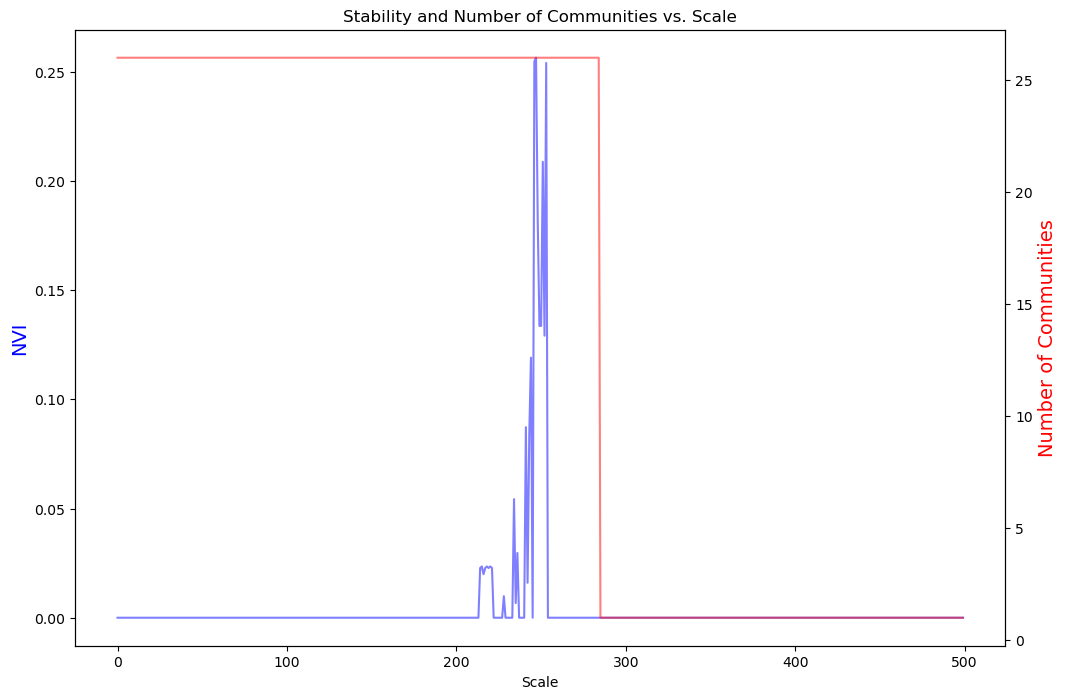

In [202]:
# plot all ['number of communities'] and ['stability'] in the all_results, and use left y-axis for stability and right y-axis for number of communities
plt.figure(figsize=(12, 8))
plt.plot(all_results['NVI'], color='blue', alpha=0.5)
plt.ylabel('NVI', color='blue', fontsize=14)
plt.xlabel('Scale')
plt.twinx()
plt.plot(all_results['number_of_communities'], color='red', alpha=0.5)
plt.ylabel('Number of Communities', color='red', fontsize=14)
plt.title('Stability and Number of Communities vs. Scale')
plt.show()

In [127]:
all_results = pgs.identify_optimal_scales(all_results,kernel_size=30,window_size=10)
all_results.keys()

dict_keys(['run_params', 'scales', 'number_of_communities', 'stability', 'community_id', 'NVI', 'ttprime', 'block_detection_curve', 'selected_partitions'])

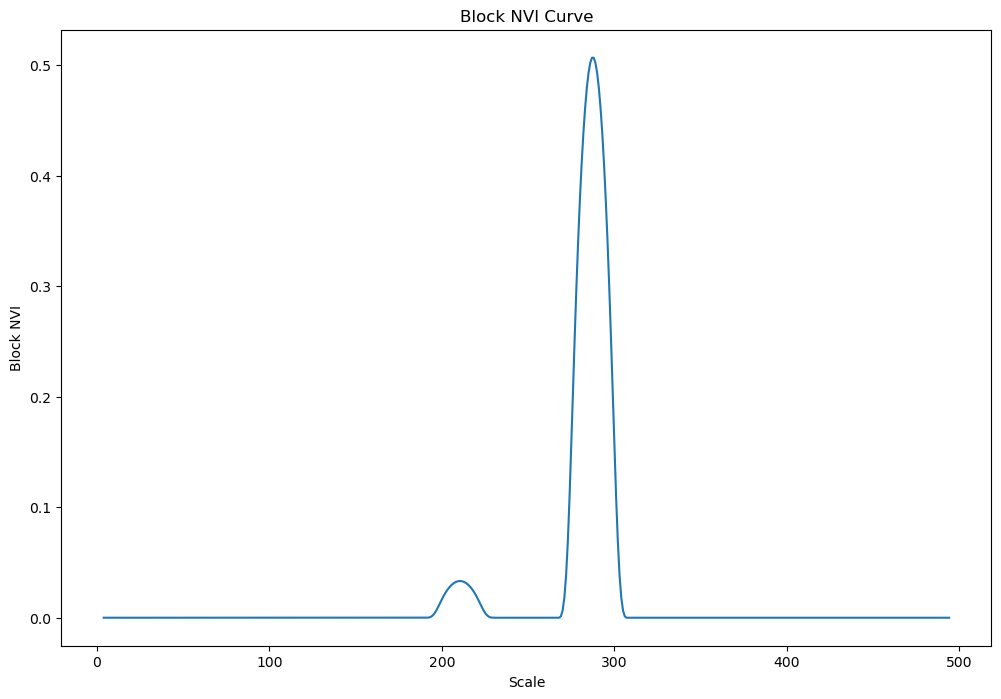

In [128]:
all_results['block_detection_curve']
#plot the block detection curve
plt.figure(figsize=(12, 8))
plt.plot(all_results['block_detection_curve'])
plt.xlabel('Scale')
plt.ylabel('Block NVI')
plt.title('Block NVI Curve')
plt.show()

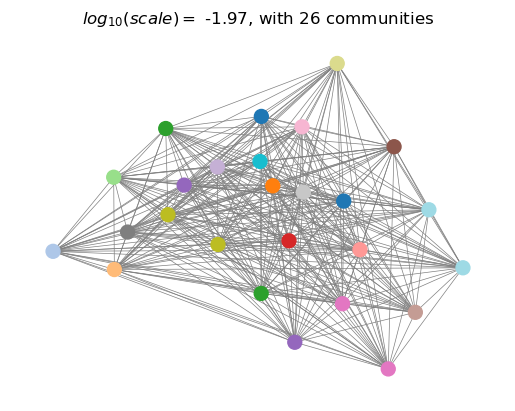

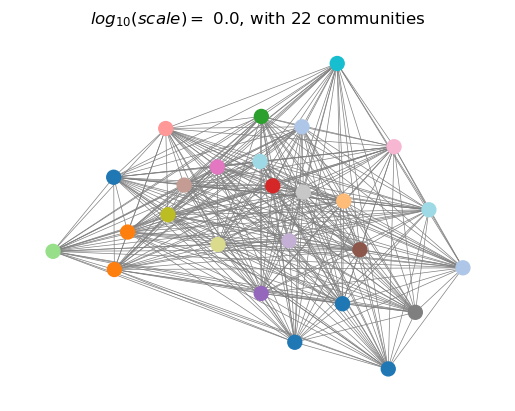

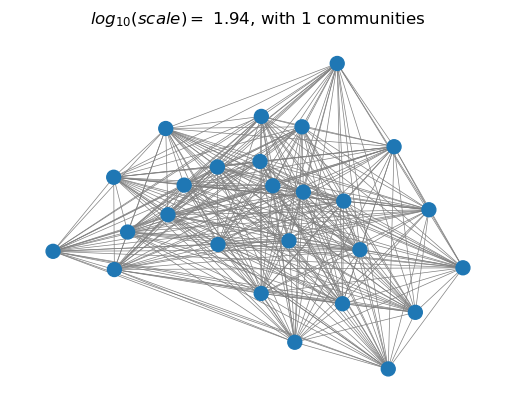

In [129]:
# plot optimal partitions
plotting.plot_optimal_partitions(G_raw, all_results, show=True)

In [130]:
community_4_cut = all_results['community_id'][240]
community_4_cut

array([ 4,  5,  6,  7,  3,  8,  9,  1, 10, 11,  0, 12, 13, 14, 15,  0,  1,
        2,  3, 16, 17, 18, 19, 20,  2, 21])

In [131]:
# iterately add a new attribute for each node in the network, the attribute is 'community_id6', and the value is based on the list community_6, same with 'community_id2'
for idx, node in enumerate(G_raw.nodes()):
    G_raw.nodes[node]['community_4_cut'] = community_4_cut[idx]

In [132]:
# substract each nodes' name, community_id6, and community_id2 to a pandas dataframe
node_df = pd.DataFrame(G_raw.nodes(data=True))
node_df['city_name'] = node_df[0].apply(lambda x: x)
node_df['community_4_cut'] = node_df[1].apply(lambda x: x['community_4_cut'])
node_df = node_df.drop([0, 1], axis=1)
# set the city_name as the index
node_df = node_df.set_index('city_name')
node_df.sample(3)

community_4_cut
city_name                               
Nantong, Jiangsu, China               14
Taizhou, Jiangsu, China                2
Chizhou, Anhui, China                  3

In [133]:
city_boundary = city_boundary.merge(node_df[['community_4_cut']], left_on='display_na', right_index=True, how='left')

C:\Users\SBH\AppData\Local\Temp\ipykernel_9004\2722237284.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



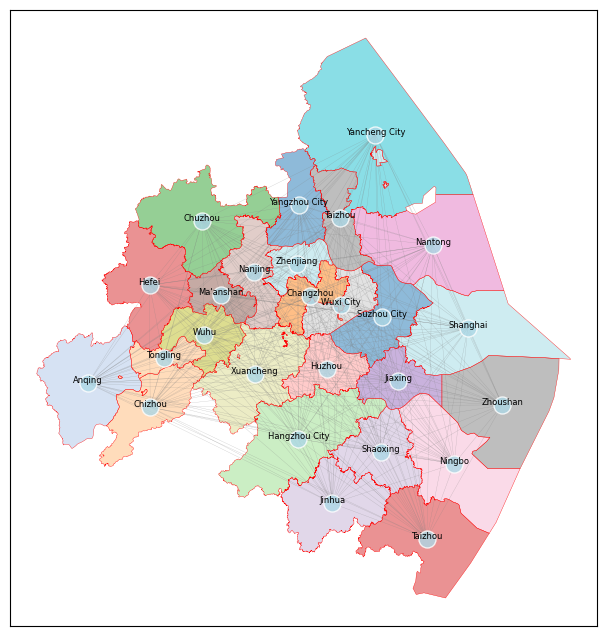

In [134]:

# 生成颜色映射
unique_communities = node_df['community_4_cut'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_communities))
community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 填充边界颜色
for community in unique_communities:
    boundary_community = city_boundary[city_boundary['community_4_cut'] == community]
    boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_cut, 'pos')

# 绘制节点
nx.draw_networkx_nodes(G_cut, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

# 绘制边，使用宽度来显示边的权重
nx.draw_networkx_edges(G_cut, pos, ax=ax, edge_color='gray', width=0.2, arrows=False, alpha=0.5)
plt.show()

In [289]:
city_boundary.columns

Index(['bbox_north', 'bbox_south', 'bbox_east', 'bbox_west', 'place_id',
       'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type', 'place_rank',
       'importance', 'addresstyp', 'name', 'display_na', 'geometry',
       'community_GMC_id_8', 'community_Bicluster_id_8',
       'community_Spectral_id_8'],
      dtype='object')

In [290]:
# only keep the 'place_id', 'display_na', 'name', 'osm_id',  'community_GMC_id_8', 'community_Bicluster_id_8', 'community_Spectral_id_8', 'community_8_cut4' from the city_boundary and save as a dataframe
city_boundary_df = city_boundary[['place_id', 'display_na', 'name', 'osm_id', 'community_GMC_id_8']]
city_boundary_df.sample(3)

place_id               display_na       name   osm_id community_GMC_id_8
8   378239909  Huzhou, Zhejiang, China     Huzhou  3149738                  1
11  196947334  Ma'anshan, Anhui, China  Ma'anshan  3260816                  0
13  197160785  Nantong, Jiangsu, China    Nantong  4430899                  0

In [291]:
# save the city_boundary_df as a csv file
#city_boundary_df.to_csv('Data/python/Partition_eco2017.csv', index=False)

In [344]:
G_raw_save = G_raw.copy()

In [345]:

# 遍历节点，清理属性
for node, data in G_raw_save.nodes(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 遍历边，清理属性
for u, v, data in G_raw_save.edges(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 保存图为 GraphML 文件
nx.write_graphml(G_raw_save, 'Data/python/Industry_network_raw.graphml')


In [1290]:
"""
G_cut_save = G_cut.copy()
# 遍历节点，清理属性
for node, data in G_cut_save.nodes(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 遍历边，清理属性
for u, v, data in G_cut_save.edges(data=True):
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = str(value)  # 将 tuple 转换为字符串

# 保存图为 GraphML 文件
nx.write_graphml(G_cut_save, 'Data/python/Industry_network_cut.graphml')
"""

### Something about dense matrix

In [ ]:
#check the raw transition matrix
Transition_matrix

0         1         2         3         4         5         6   \
0    0.000000  2.660147  0.952428  5.900496  0.506231  1.800453  6.696708   
1   14.397360  0.000000  0.879648  5.873380  0.472847  1.945515  6.851408   
2   13.661005  2.259924  0.000000  3.869707  0.374791  1.816148  6.291673   
3   14.345348  2.734131  0.754082  0.000000  0.519277  1.899943  6.063282   
4   10.407519  2.862023  1.210031  5.674345  0.000000  2.869688  6.668950   
5   10.929041  2.942493  1.093749  6.501033  0.451928  0.000000  7.007125   
6   13.163692  2.621906  0.831804  5.587419  0.291557  1.484278  0.000000   
7   12.579316  2.790318  0.946529  6.401456  0.339535  2.264687  6.844604   
8   14.337252  2.556730  0.829428  5.274413  0.405756  1.789866  7.577213   
9   13.233422  2.800996  1.207421  5.041841  0.370425  1.718791  7.747562   
10  13.653165  2.970899  0.964545  6.204555  0.421318  1.909494  6.870740   
11  11.643813  2.551865  1.001582  5.424975  1.060334  2.636650  6.619450   
12  12.892770  2.489449  1.059707  5.302411  0.508320  1.872989  6.503668   
13  13.666361  2.761151  0.925738  6.230924  0.385998  1.847447  7.280700   
14  15.096501  2.540406  1.129223  4.962903  0.336161  1.545015  6.109561   
15  14.238353  2.667996  0.999143  5.196399  0.368065  1.291413  7.751245   
16  17.272702  2.303678  0.679394  5.448278  0.248322  1.291848  6.817081   
17  13.260758  2.522224  1.202047  4.956227  0.420209  2.573265  8.105880   
18  10.058533  3.167792  1.024091  5.783123  1.298597  2.257345  5.261294   
19  13.620468  2.830286  0.851568  6.671701  0.592499  1.713314  6.017406   
20  17.355337  2.387264  0.854936  4.747318  0.336144  1.911910  7.105729   
21  14.366062  2.455815  1.128987  4.873561  0.526470  2.276881  7.455826   
22  13.647433  2.779089  1.013811  5.918173  0.505836  2.524070  7.477911   
23  14.823853  2.565882  1.071899  5.596744  0.484191  2.055441  6.632900   
24   9.036701  2.028174  2.005012  2.752247  0.524405  2.193139  5.040188   
25  15.628761  2.261384  0.916513  4.807933  0.317576  1.576853  6.775416   

          7         8         9   ...        16        17        18        19  \
0   3.199986  2.765537  5.021223  ...  1.182357  2.665363  1.322420  8.337394   
1   4.059109  2.501965  4.855800  ...  1.072585  2.506916  1.244562  8.037457   
2   3.451608  1.713325  5.681643  ...  0.842764  2.929835  0.557645  5.845911   
3   4.135514  2.364404  4.276164  ...  1.130629  2.549743  1.320654  8.983446   
4   3.305906  3.326031  4.660174  ...  0.623885  2.882547  3.519924  8.073687   
5   4.500550  2.804249  4.653075  ...  0.803997  3.117498  0.834665  7.162892   
6   3.209169  2.958904  5.319615  ...  1.365325  2.714398  0.612249  7.478538   
7   0.000000  2.501393  4.396229  ...  1.180417  2.598188  0.545820  7.520630   
8   3.767763  0.000000  6.298643  ...  1.161011  2.369548  0.856202  7.386133   
9   2.983914  3.891593  0.000000  ...  0.985563  2.300207  0.751803  6.694139   
10  3.828436  2.974750  5.553737  ...  1.216157  2.647437  0.840160  7.274890   
11  3.217346  3.229017  4.693522  ...  0.705146  2.921640  3.283666  8.383265   
12  3.648470  2.014669  4.293815  ...  1.042699  2.753298  1.374267  7.664511   
13  3.061647  2.685044  4.631538  ...  1.303010  3.554097  0.644549  7.888881   
14  3.921534  1.919501  4.968685  ...  1.113160  2.315825  0.752159  7.176090   
15  2.497854  3.449405  6.727482  ...  1.211822  2.562671  0.923536  7.805326   
16  4.224905  2.011823  4.065734  ...  0.000000  2.653599  0.389181  8.422888   
17  3.615260  2.429289  4.077939  ...  1.100180  0.000000  0.653247  6.450656   
18  2.299690  2.416461  3.498930  ...  0.565908  2.476123  0.000000  9.517659   
19  3.465822  2.567419  4.613017  ...  1.188943  2.483394  1.674011  0.000000   
20  5.156278  1.847338  4.398420  ...  1.098513  2.094409  0.713104  7.304187   
21  4.077380  2.780219  4.751642  ...  0.923683  2.775399  1.188311  6.679726   
22  4.150716  2.885007  5.068977  ...  0.924421  2.851950  1.084119 

In [ ]:
# convert the Transition_matrix to a numpy array
Transition_matrix_cut_array = Transition_matrix_cut.values

# calculate the sum of each row in the Transition_matrix_array
row_sums_cut = Transition_matrix_cut_array.sum(axis=1)
# and then normalize the Transition_matrix_array
normalized_transition_matrix_cut = Transition_matrix_cut_array / row_sums_cut[:, np.newaxis]

# calculate the eigenvalues and eigenvectors of the normalized_transition_matrix
eigenvalues, eigenvectors = np.linalg.eig(normalized_transition_matrix_cut)
print(eigenvalues)

[ 1.00000000e+00+0.j         -3.57813727e-01+0.j
 -2.73566161e-01+0.j          1.58536983e-01+0.03733889j
  1.58536983e-01-0.03733889j -2.08239009e-01+0.j
 -1.53769851e-01+0.05152239j -1.53769851e-01-0.05152239j
  9.21653005e-02+0.j          6.54557676e-02+0.04094032j
  6.54557676e-02-0.04094032j -1.11618931e-01+0.j
  6.88183030e-02+0.j         -2.57189102e-02+0.05749266j
 -2.57189102e-02-0.05749266j -7.26067209e-02+0.0071483j
 -7.26067209e-02-0.0071483j  -5.15095394e-02+0.02949748j
 -5.15095394e-02-0.02949748j -1.37915922e-02+0.02156859j
 -1.37915922e-02-0.02156859j -2.08279789e-02+0.j
  3.83585259e-03+0.00900051j  3.83585259e-03-0.00900051j
 -1.00887334e-02+0.j          3.06956600e-04+0.j        ]


In [ ]:
# convert the Transition_matrix to a numpy array
Transition_matrix_array = Transition_matrix.values

# calculate the sum of each row in the Transition_matrix_array
row_sums = Transition_matrix_array.sum(axis=1)
# and then normalize the Transition_matrix_array
normalized_transition_matrix = Transition_matrix_array / row_sums[:, np.newaxis]

# calculate the eigenvalues and eigenvectors of the normalized_transition_matrix
eigenvalues, eigenvectors = np.linalg.eig(normalized_transition_matrix)
print(eigenvalues)

[ 1.        +0.j         -0.16405127+0.j         -0.1329109 +0.j
 -0.09187111+0.j          0.03300184+0.j         -0.07808994+0.0015407j
 -0.07808994-0.0015407j  -0.07064627+0.j          0.01560061+0.j
 -0.0600283 +0.j         -0.0539594 +0.j          0.00380945+0.j
  0.00227416+0.j         -0.04555391+0.j         -0.00856839+0.j
 -0.01006839+0.j         -0.01405414+0.j         -0.01572748+0.j
 -0.0363533 +0.000338j   -0.0363533 -0.000338j   -0.02150036+0.00075363j
 -0.02150036-0.00075363j -0.02548303+0.j         -0.02738441+0.j
 -0.03033544+0.j         -0.0321564 +0.j        ]


ValueError: 3 is not in list

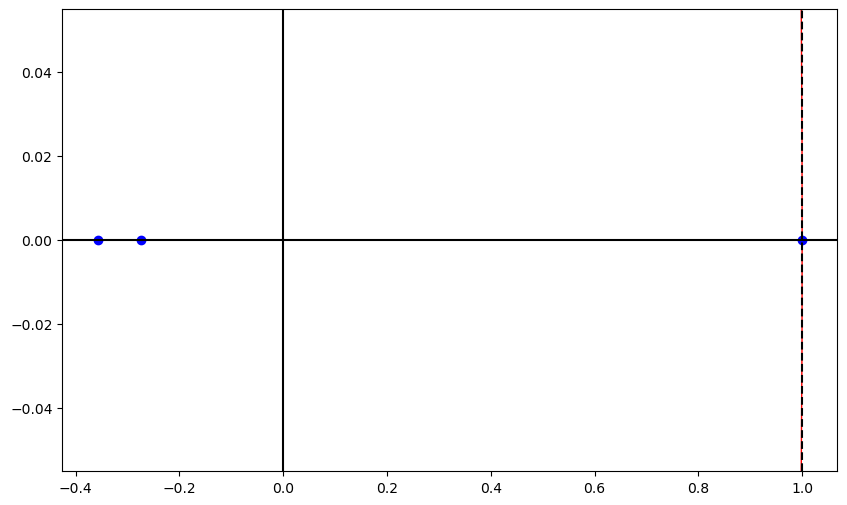

In [ ]:
"""
# 定义特征值
eigenvalues = np.array([1. + 0.j, -0.16405127 + 0.j, -0.1329109 + 0.j, -0.09187111 + 0.j,
                        0.03300184 + 0.j, -0.07808994 + 0.0015407j, -0.07808994 - 0.0015407j,
                        -0.07064627 + 0.j, 0.01560061 + 0.j, -0.0600283 + 0.j, -0.0539594 + 0.j,
                        0.00380945 + 0.j, 0.00227416 + 0.j, -0.04555391 + 0.j, -0.00856839 + 0.j,
                        -0.01006839 + 0.j, -0.01405414 + 0.j, -0.01572748 + 0.j, -0.0363533 + 0.000338j,
                        -0.0363533 - 0.000338j, -0.02150036 + 0.00075363j, -0.02150036 - 0.00075363j,
                        -0.02548303 + 0.j, -0.02738441 + 0.j, -0.03033544 + 0.j, -0.0321564 + 0.j])
"""

# 分离实部和虚部
real_parts = np.real(eigenvalues)
imaginary_parts = np.imag(eigenvalues)

# 找出复数特征值对
complex_pairs_indices = [5, 6, 18, 19, 20, 21]  # 复数特征值对的索引
colors = ['orange', 'orange', 'purple', 'purple', 'green', 'green']  # 给复数共轭特征值对指定不同的颜色

# 创建图表
plt.figure(figsize=(10, 6))



# 绘制实部=1的红线
plt.axvline(x=1, color='black', linestyle='--', linewidth=1.5, label='Real Part = 1')

# 绘制实部=0和虚部=0的加粗线
plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

# 绘制单位圆
circle = plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, label='Unit Circle |z| < 1')
plt.gca().add_artist(circle)

# 绘制实部和虚部的散点图
for i in range(len(real_parts)):
    if imaginary_parts[i] != 0:
        color = colors[complex_pairs_indices.index(i)]
        plt.scatter(real_parts[i], imaginary_parts[i], color=color, label=f'Conjugate Pair {complex_pairs_indices.index(i)//2 + 1}' if imaginary_parts[i] > 0 else "")
    else:
        plt.scatter(real_parts[i], imaginary_parts[i], color='blue')

# 添加标题和标签
plt.title('Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

# 显示图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

# 显示网格
plt.grid(False)

# 显示图表
plt.show()